# Install and Import Requirements

In [1]:
!pip install -q peft
!pip install -q peft evaluate datasets

In [2]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from transformers import BertTokenizer, BertModel, DataCollatorWithPadding, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, EarlyStoppingCallback, Trainer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from datasets import DatasetDict, Dataset

import evaluate
from peft import LoraConfig, TaskType, get_peft_model

import itertools
import json
from datetime import datetime

# Load Data and Divice into Tokenized Datasets

In [3]:
# allows code to run correctly on either CPU or GPU (used later)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("/content/final_dataset.csv") # can be downloaded from GitHub repo, which also contains annotated Colab for dataset creation

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# split into training (70%), validation (10%), and testing (20%) dataframes
temp_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_df, val_df = train_test_split(temp_df, test_size=0.125, stratify=temp_df["label"], random_state=73)

# create datasets from pandas dataframes
train_dataset = Dataset.from_pandas(train_df[['input', 'label']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['input', 'label']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['input', 'label']].reset_index(drop=True))

# inspired by this video: https://www.youtube.com/watch?v=4QHg8Ix8WWQ
def tokenize_func(examples):
  return tokenizer(examples["input"], truncation=True, max_length=128)

# tokenize "input" colums using function
tokenized_train = train_dataset.map(tokenize_func, batched=True, remove_columns="input")
tokenized_val = val_dataset.map(tokenize_func, batched=True, remove_columns="input")
tokenized_test = test_dataset.map(tokenize_func, batched=True, remove_columns="input")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/6475 [00:00<?, ? examples/s]

Map:   0%|          | 0/925 [00:00<?, ? examples/s]

Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

# Evaluation Setup

In [4]:
# loads all metrics from evaluate
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # used Claude to write code to calculate multiple training metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average='binary')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='binary')
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='binary')

    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision['precision'],
        'recall': recall['recall'],
        'f1': f1['f1'],
        # for printed confusion matrix
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn,
        'true_negatives': tn,
    }

This compute_metrics function returns all metrics I'll need to analyze model performance, along with those necessary to generate a confusion matrix.

# Training Setup

In [5]:
# weighted trainer, code from Claude to improve model training w/ class imbalance
class WeightedTrainer(Trainer):
    def __init__(self, *args, pos_weight_mult, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight_mult = pos_weight_mult
        self._loss_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # calculates weights
        if self._loss_weights is None:
            n_samples = len(train_df)
            n_positive = train_df['label'].sum()
            n_negative = n_samples - n_positive
            # weights based on class imbalance * positive weight
            pos_weight = (n_negative / n_positive) * self.pos_weight_mult
            self._loss_weights = torch.tensor([1.0, pos_weight], dtype=torch.float32).to(logits.device)
            print(f"Using pos_weight: {pos_weight:.3f}")

        # cross entropy since 2 labels
        loss_fct = nn.CrossEntropyLoss(weight=self._loss_weights)
        loss = loss_fct(logits.view(-1, 2), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

I compiled a dataset with a large class imbalance (75.73% labelled no hallucination vs 24.27% labelled hallucination), so in order to dissuade the model from always predicting the majority class I used Claude to implement a custom weighted loss class which weights the loss to more heavily penalize mistakes in labelling the minority class. It determines the ratio of negative samples (the majority, no hallucination) to positive samples (the minority, hallucination) and then multiplies by pos_weight (values explored in hyperparameter search) to determine the weight on the cross entropy loss. Ultimately, this didn't significantly improve model performance - see my analysis section for more specific results.

In [6]:
# function to train model, will use in hyperparam grid search but also for normal model training
def train_full_model(number, train_dataset, val_dataset, tokenizer, lora_config, learning_rate, pos_weight_mult, is_search):
  # define model
  model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
  model = get_peft_model(model, lora_config)

  if is_search:
    save_strategy = "no"
    save_total_limit = None
    load_best_model_at_end = False
  else:
    save_strategy = "epoch"
    save_total_limit = 2
    load_best_model_at_end = True

  training_args = TrainingArguments(
      output_dir=f"./model_train_{number}_{is_search}",
      eval_strategy="epoch",
      save_strategy=save_strategy,
      save_total_limit=save_total_limit,
      num_train_epochs=10,
      per_device_train_batch_size=16,
      per_device_eval_batch_size=32,
      learning_rate=learning_rate,
      lr_scheduler_type="cosine",

      # Claude code to improve model training by decreasing memorization and stabilizing learning
      weight_decay=0.01,
      warmup_ratio=0.1,

      # Claude code to prevent unecessary logging
      report_to=[],
      logging_strategy="epoch",

      load_best_model_at_end=load_best_model_at_end,
      metric_for_best_model="f1",
      greater_is_better=True,

      # for result reproducability
      seed=42,

      fp16=torch.cuda.is_available(),
  )

  # Claude code to implement early stopping
  early_stopping = EarlyStoppingCallback(
      early_stopping_patience=3
  )


  # create trainer from weighted trainer class
  trainer = WeightedTrainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      compute_metrics=compute_metrics,
      tokenizer=tokenizer,
      callbacks=[early_stopping],
      pos_weight_mult=pos_weight_mult,
  )

  trainer.train()

  # final val metrics
  eval_results = trainer.evaluate()

  # returns all this for grid search
  return model, eval_results, trainer.state.best_metric

# Hyperparemeter Grid Search
Important notice: this code was written by Claude so I could focus on model analysis and improvement

In [7]:
# Hyperparameter grid, small so that it could complete in ~3 hours
PARAM_GRID = {
    'r': [8, 16],
    'lora_alpha': [16, 32],
    'lora_dropout': [0.15, 0.2],
    'pos_weight_mult': [1.2, 1.3],
    'learning_rate': [2e-4]
}

# Generate combinations
param_combinations = [dict(zip(PARAM_GRID.keys(), values))
                     for values in itertools.product(*PARAM_GRID.values())]

# Run grid search
all_results = []
for idx, params in enumerate(param_combinations, 1):
    print(f"\nConfig {idx}/{len(param_combinations)}: {params}")

    # Create LoRA config
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=params['r'],
        lora_alpha=params['lora_alpha'],
        lora_dropout=params['lora_dropout'],
        target_modules=["query", "key", "value"],
        bias="none"
    )

    # Train
    model, eval_results, best_f1 = train_full_model(
        idx,
        tokenized_train,
        tokenized_val,
        tokenizer,
        lora_config,
        params['learning_rate'],
        params['pos_weight_mult'],
        is_search="hyperparam_search"
    )

    # Store results
    all_results.append({
        'config_id': idx,
        'params': params,
        'best_f1': best_f1,
        'final_f1': eval_results['eval_f1'],
        'final_accuracy': eval_results['eval_accuracy'],
        'final_precision': eval_results['eval_precision'],
        'final_recall': eval_results['eval_recall']
    })

    print(f"  Best F1: {best_f1:.4f}")

# Sort and show best
all_results.sort(key=lambda x: x['best_f1'], reverse=True)
print(f"\n🏆 Best config: {all_results[0]['params']}")
print(f"   F1 score: {all_results[0]['best_f1']:.4f}")


Config 1/16: {'r': 8, 'lora_alpha': 16, 'lora_dropout': 0.15, 'pos_weight_mult': 1.2, 'learning_rate': 0.0002}


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 3.743


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.688600,0.650454,0.516757,0.303351,0.767857,0.434893,172,395,52,306
2,0.650000,0.631997,0.624865,0.343511,0.602679,0.437601,135,258,89,443
3,0.627200,0.601598,0.571892,0.329365,0.741071,0.456044,166,338,58,363
4,0.604900,0.626913,0.660541,0.375000,0.602679,0.462329,135,225,89,476
5,0.582200,0.617615,0.593514,0.338298,0.709821,0.458213,159,311,65,390
6,0.557800,0.651007,0.704865,0.410256,0.500000,0.450704,112,161,112,540
7,0.533400,0.696773,0.696216,0.396364,0.486607,0.436874,109,166,115,535


  Best F1: 0.4623

Config 2/16: {'r': 8, 'lora_alpha': 16, 'lora_dropout': 0.15, 'pos_weight_mult': 1.3, 'learning_rate': 0.0002}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 4.055


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.687300,0.638670,0.481081,0.294872,0.821429,0.433962,184,440,40,261
2,0.639000,0.625594,0.659459,0.360856,0.526786,0.428312,118,209,106,492
3,0.615000,0.605211,0.568649,0.325349,0.727679,0.449655,163,338,61,363
4,0.599200,0.623034,0.647568,0.347305,0.517857,0.415771,116,218,108,483
5,0.575200,0.621313,0.549189,0.314066,0.727679,0.438762,163,356,61,345
6,0.549800,0.651449,0.659459,0.365782,0.553571,0.440497,124,215,100,486


  Best F1: 0.4497

Config 3/16: {'r': 8, 'lora_alpha': 16, 'lora_dropout': 0.2, 'pos_weight_mult': 1.2, 'learning_rate': 0.0002}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 3.743


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.692200,0.643547,0.514595,0.307033,0.799107,0.443618,179,404,45,297
2,0.653500,0.628429,0.618378,0.340741,0.616071,0.438792,138,267,86,434
3,0.631500,0.611358,0.608649,0.333333,0.616071,0.432602,138,276,86,425
4,0.613300,0.613931,0.637838,0.350404,0.580357,0.436975,130,241,94,460


  Best F1: 0.4436

Config 4/16: {'r': 8, 'lora_alpha': 16, 'lora_dropout': 0.2, 'pos_weight_mult': 1.3, 'learning_rate': 0.0002}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 4.055


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.686100,0.632885,0.516757,0.299820,0.745536,0.427657,167,390,57,311
2,0.638900,0.621853,0.608649,0.331707,0.607143,0.429022,136,274,88,427
3,0.613100,0.615474,0.605405,0.337931,0.656250,0.446131,147,288,77,413
4,0.597400,0.625581,0.660541,0.367647,0.558036,0.443262,125,215,99,486
5,0.571000,0.619747,0.572973,0.317697,0.665179,0.430014,149,320,75,381
6,0.543700,0.653971,0.645405,0.361702,0.607143,0.453333,136,240,88,461
7,0.511500,0.738757,0.723243,0.434426,0.473214,0.452991,106,138,118,563
8,0.498700,0.716270,0.648649,0.363881,0.602679,0.453782,135,236,89,465
9,0.475200,0.746307,0.661622,0.370262,0.566964,0.447972,127,216,97,485
10,0.472100,0.744797,0.656216,0.367232,0.580357,0.449827,130,224,94,477


  Best F1: 0.4538

Config 5/16: {'r': 8, 'lora_alpha': 32, 'lora_dropout': 0.15, 'pos_weight_mult': 1.2, 'learning_rate': 0.0002}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 3.743


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.684100,0.645079,0.624865,0.334232,0.553571,0.416807,124,247,100,454
2,0.639300,0.619370,0.664865,0.375000,0.575893,0.454225,129,215,95,486
3,0.613900,0.611180,0.555676,0.318447,0.732143,0.443843,164,351,60,350
4,0.594500,0.635640,0.649730,0.362637,0.589286,0.448980,132,232,92,469
5,0.560000,0.629415,0.571892,0.329365,0.741071,0.456044,166,338,58,363
6,0.534000,0.673277,0.674595,0.379310,0.540179,0.445672,121,198,103,503
7,0.489900,0.780010,0.718919,0.419643,0.419643,0.419643,94,130,130,571
8,0.468500,0.757256,0.656216,0.362573,0.553571,0.438163,124,218,100,483


  Best F1: 0.4560

Config 6/16: {'r': 8, 'lora_alpha': 32, 'lora_dropout': 0.15, 'pos_weight_mult': 1.3, 'learning_rate': 0.0002}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 4.055


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.683100,0.629441,0.561081,0.318000,0.709821,0.439227,159,341,65,360
2,0.635400,0.618628,0.628108,0.346154,0.602679,0.439739,135,255,89,446
3,0.611200,0.618615,0.557838,0.325142,0.767857,0.456839,172,357,52,344
4,0.586200,0.646880,0.611892,0.338902,0.633929,0.441680,142,277,82,424
5,0.542500,0.666396,0.549189,0.319626,0.763393,0.450593,171,364,53,337
6,0.514100,0.685472,0.623784,0.338542,0.580357,0.427632,130,254,94,447


  Best F1: 0.4568

Config 7/16: {'r': 8, 'lora_alpha': 32, 'lora_dropout': 0.2, 'pos_weight_mult': 1.2, 'learning_rate': 0.0002}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 3.743


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.688000,0.635540,0.537297,0.306084,0.718750,0.429333,161,365,63,336
2,0.643800,0.610741,0.606486,0.331731,0.616071,0.431250,138,278,86,423
3,0.622000,0.612877,0.551351,0.315280,0.727679,0.439946,163,354,61,347
4,0.593500,0.650560,0.662703,0.374286,0.584821,0.456446,131,219,93,482
5,0.556800,0.640293,0.555676,0.319846,0.741071,0.446837,166,353,58,348
6,0.527900,0.710070,0.683243,0.380623,0.491071,0.428850,110,179,114,522
7,0.490000,0.830773,0.723243,0.427928,0.424107,0.426009,95,127,129,574


  Best F1: 0.4564

Config 8/16: {'r': 8, 'lora_alpha': 32, 'lora_dropout': 0.2, 'pos_weight_mult': 1.3, 'learning_rate': 0.0002}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 4.055


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.686000,0.627837,0.528649,0.307273,0.754464,0.436693,169,381,55,320
2,0.640000,0.642315,0.585946,0.315545,0.607143,0.415267,136,295,88,406
3,0.625400,0.615438,0.581622,0.326964,0.687500,0.443165,154,317,70,384
4,0.593700,0.648562,0.676757,0.380952,0.535714,0.445269,120,195,104,506
5,0.557300,0.634907,0.582703,0.324675,0.669643,0.437318,150,312,74,389
6,0.522800,0.676200,0.623784,0.346535,0.625000,0.445860,140,264,84,437
7,0.478200,0.864036,0.724324,0.425121,0.392857,0.408353,88,119,136,582
8,0.459400,0.806653,0.647568,0.350000,0.531250,0.421986,119,221,105,480
9,0.428200,0.868381,0.681081,0.378840,0.495536,0.429400,111,182,113,519


  Best F1: 0.4459

Config 9/16: {'r': 16, 'lora_alpha': 16, 'lora_dropout': 0.15, 'pos_weight_mult': 1.2, 'learning_rate': 0.0002}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 3.743


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.691800,0.634362,0.515676,0.310169,0.816964,0.449631,183,407,41,294
2,0.644900,0.612323,0.631351,0.348837,0.602679,0.441899,135,252,89,449
3,0.619600,0.609619,0.577297,0.329243,0.718750,0.451613,161,328,63,373
4,0.601900,0.627460,0.660541,0.375000,0.602679,0.462329,135,225,89,476
5,0.571600,0.627692,0.570811,0.325956,0.723214,0.449376,162,335,62,366
6,0.552900,0.655542,0.671351,0.378788,0.558036,0.451264,125,205,99,496
7,0.524100,0.742975,0.718919,0.424370,0.450893,0.437229,101,137,123,564


  Best F1: 0.4623

Config 10/16: {'r': 16, 'lora_alpha': 16, 'lora_dropout': 0.15, 'pos_weight_mult': 1.3, 'learning_rate': 0.0002}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 4.055


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.687000,0.631726,0.495135,0.299835,0.812500,0.438026,182,425,42,276
2,0.637500,0.619606,0.642162,0.352617,0.571429,0.436116,128,235,96,466
3,0.615500,0.610123,0.569730,0.328063,0.741071,0.454795,166,340,58,361
4,0.596100,0.629357,0.662703,0.369822,0.558036,0.444840,125,213,99,488
5,0.567600,0.627091,0.552432,0.320755,0.758929,0.450928,170,360,54,341
6,0.541200,0.665673,0.650811,0.360563,0.571429,0.442142,128,227,96,474


  Best F1: 0.4548

Config 11/16: {'r': 16, 'lora_alpha': 16, 'lora_dropout': 0.2, 'pos_weight_mult': 1.2, 'learning_rate': 0.0002}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 3.743


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.692400,0.646344,0.528649,0.310714,0.776786,0.443878,174,386,50,315
2,0.649400,0.617147,0.614054,0.330789,0.580357,0.421394,130,263,94,438
3,0.626300,0.610417,0.558919,0.327715,0.781250,0.461741,175,359,49,342
4,0.606300,0.619635,0.629189,0.346253,0.598214,0.438625,134,253,90,448
5,0.576800,0.627102,0.535135,0.314079,0.776786,0.447301,174,380,50,321
6,0.552000,0.650841,0.677838,0.380645,0.526786,0.441948,118,192,106,509


  Best F1: 0.4617

Config 12/16: {'r': 16, 'lora_alpha': 16, 'lora_dropout': 0.2, 'pos_weight_mult': 1.3, 'learning_rate': 0.0002}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 4.055


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.691300,0.646040,0.523243,0.305903,0.763393,0.436782,171,388,53,313
2,0.649900,0.623954,0.618378,0.337531,0.598214,0.431562,134,263,90,438
3,0.619200,0.606943,0.558919,0.321705,0.741071,0.448649,166,350,58,351
4,0.601700,0.622857,0.608649,0.341743,0.665179,0.451515,149,287,75,414
5,0.572900,0.625454,0.527568,0.312830,0.794643,0.448928,178,391,46,310
6,0.550500,0.676762,0.681081,0.385113,0.531250,0.446529,119,190,105,511
7,0.525400,0.756681,0.711351,0.413655,0.459821,0.435518,103,146,121,555


  Best F1: 0.4515

Config 13/16: {'r': 16, 'lora_alpha': 32, 'lora_dropout': 0.15, 'pos_weight_mult': 1.2, 'learning_rate': 0.0002}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 3.743


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.685300,0.630539,0.552432,0.313725,0.714286,0.435967,160,350,64,351
2,0.633900,0.623077,0.644324,0.355372,0.575893,0.439523,129,234,95,467
3,0.607800,0.609751,0.592432,0.334773,0.691964,0.451237,155,308,69,393
4,0.585800,0.642671,0.665946,0.373134,0.558036,0.447227,125,210,99,491
5,0.546500,0.640459,0.564324,0.328872,0.767857,0.460509,172,351,52,350
6,0.506300,0.691256,0.670270,0.377644,0.558036,0.450450,125,206,99,495
7,0.457900,0.872796,0.751351,0.484043,0.406250,0.441748,91,97,133,604
8,0.441800,0.790426,0.667027,0.375740,0.566964,0.451957,127,211,97,490


  Best F1: 0.4605

Config 14/16: {'r': 16, 'lora_alpha': 32, 'lora_dropout': 0.15, 'pos_weight_mult': 1.3, 'learning_rate': 0.0002}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 4.055


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.683700,0.628123,0.543784,0.309615,0.718750,0.432796,161,359,63,342
2,0.636900,0.620906,0.620541,0.338422,0.593750,0.431118,133,260,91,441
3,0.610900,0.621023,0.551351,0.315992,0.732143,0.441454,164,355,60,346
4,0.585500,0.637590,0.615135,0.340580,0.629464,0.442006,141,273,83,428
5,0.540700,0.660922,0.563243,0.319277,0.709821,0.440443,159,339,65,362
6,0.503200,0.706131,0.611892,0.340426,0.642857,0.445131,144,279,80,422
7,0.457100,0.904125,0.710270,0.404348,0.415179,0.409692,93,137,131,564
8,0.426300,0.866267,0.640000,0.354667,0.593750,0.444073,133,242,91,459
9,0.406500,0.914096,0.665946,0.372372,0.553571,0.445242,124,209,100,492
10,0.400700,0.905945,0.661622,0.371758,0.575893,0.451839,129,218,95,483


  Best F1: 0.4518

Config 15/16: {'r': 16, 'lora_alpha': 32, 'lora_dropout': 0.2, 'pos_weight_mult': 1.2, 'learning_rate': 0.0002}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 3.743


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.683200,0.622917,0.568649,0.324649,0.723214,0.448133,162,337,62,364
2,0.638100,0.615053,0.647568,0.359116,0.580357,0.443686,130,232,94,469
3,0.613500,0.604538,0.584865,0.338057,0.745536,0.465181,167,327,57,374
4,0.597400,0.632227,0.651892,0.362360,0.575893,0.444828,129,227,95,474
5,0.560300,0.625639,0.589189,0.340816,0.745536,0.467787,167,323,57,378
6,0.526400,0.650681,0.673514,0.383929,0.575893,0.460714,129,207,95,494
7,0.473600,0.816885,0.745946,0.471503,0.406250,0.436451,91,102,133,599
8,0.460900,0.737628,0.678919,0.384127,0.540179,0.448980,121,194,103,507


  Best F1: 0.4678

Config 16/16: {'r': 16, 'lora_alpha': 32, 'lora_dropout': 0.2, 'pos_weight_mult': 1.3, 'learning_rate': 0.0002}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 4.055


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.683500,0.634330,0.570811,0.319415,0.683036,0.435277,153,326,71,375
2,0.640500,0.623910,0.641081,0.349162,0.558036,0.429553,125,233,99,468
3,0.615400,0.619497,0.563243,0.321429,0.723214,0.445055,162,342,62,359
4,0.590000,0.648783,0.647568,0.359890,0.584821,0.445578,131,233,93,468
5,0.547900,0.638893,0.556757,0.319066,0.732143,0.444444,164,350,60,351
6,0.512400,0.703505,0.642162,0.357333,0.598214,0.447412,134,241,90,460
7,0.470600,0.872661,0.730811,0.437186,0.388393,0.411348,87,112,137,589
8,0.445100,0.814499,0.661622,0.368732,0.558036,0.444050,125,214,99,487
9,0.414500,0.872124,0.675676,0.375817,0.513393,0.433962,115,191,109,510


  Best F1: 0.4474

🏆 Best config: {'r': 16, 'lora_alpha': 32, 'lora_dropout': 0.2, 'pos_weight_mult': 1.2, 'learning_rate': 0.0002}
   F1 score: 0.4678


In this hyperparameter search, epoch 4 of configuration 1 ('r': 8, 'lora_alpha': 16, 'lora_dropout': 0.15, 'pos_weight_mult': 1.2, 'learning_rate': 0.0002) yields the highest F1 value at 0.4861. However, the configuration with the lowest maximum F1, configuration 11 ('r': 16, 'lora_alpha': 16, 'lora_dropout': 0.2, 'pos_weight_mult': 1.2, 'learning_rate': 0.0002), achieves an F1 of 0.4458, only ~0.04 lower. This lack of variation in F1 suggests that this model's poor performance cannot be significantly improved with hyperparameter optimization.

# Statistics
I've used hard-coded values to display these graphs so that it isn't necessary to run the above hyperparameter search to view them. The below cells include a confusion matrix and a loss plot for configuration 15, epoch 4, the model with the highest F1 value.

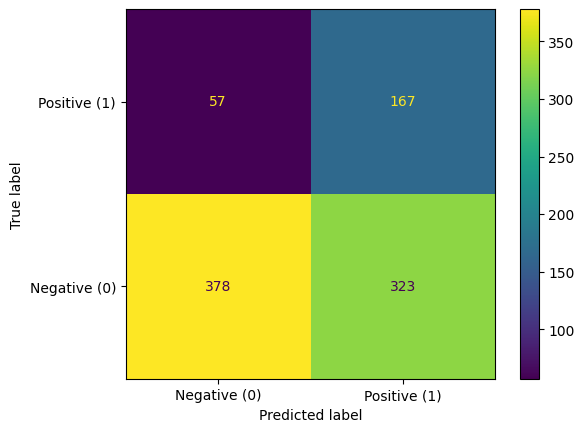

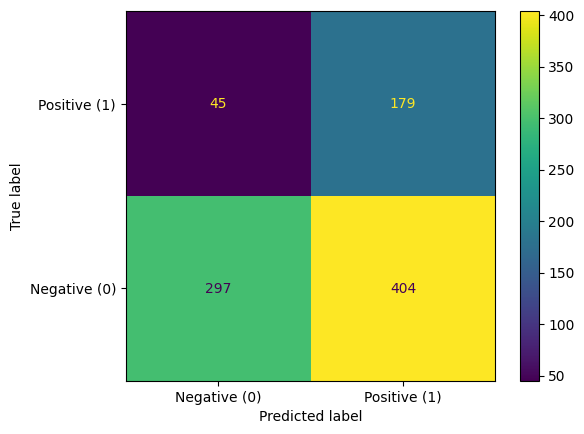

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
from sklearn import metrics
import numpy as np

# from the tables displayed in the hyperparameter search
best_confusion_matrix = np.array([[378, 323], [57, 167]])
worst_confusion_matrix = np.array([[297, 404], [45, 179]])

best_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = best_confusion_matrix, display_labels = ['Negative (0)', 'Positive (1)'])
worst_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = worst_confusion_matrix, display_labels = ['Negative (0)', 'Positive (1)'])

import matplotlib.pyplot as plt

best_cm_display.plot()
plt.gca().invert_yaxis()
plt.savefig('confusion_matrix_best.png', dpi=300, bbox_inches='tight')
plt.show()

worst_cm_display.plot()
plt.gca().invert_yaxis()
plt.savefig('confusion_matrix_worst.png', dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download('confusion_matrix_best.png')
files.download('confusion_matrix_worst.png')

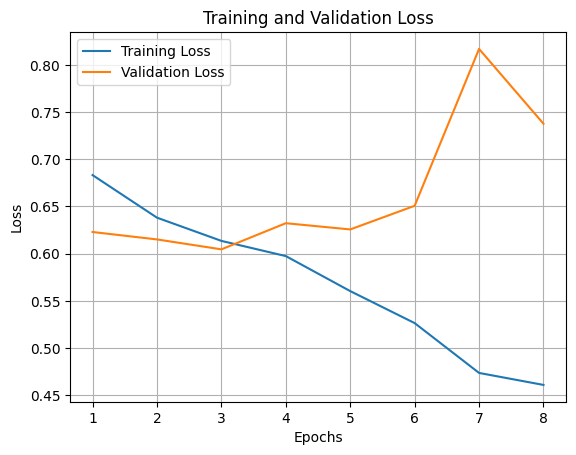

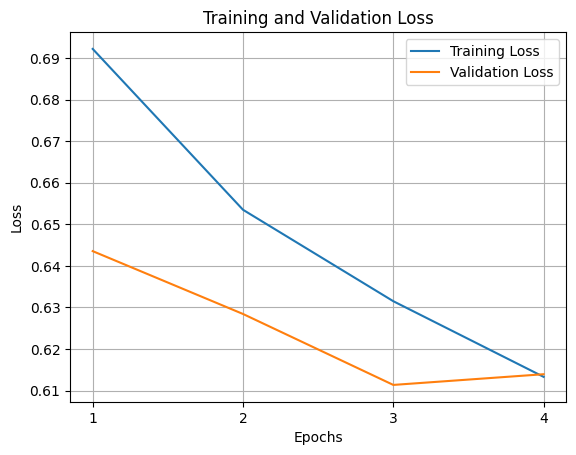

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
from matplotlib.pylab import plt

best_epochs = range(1, 9)

# training and validation values from configuration 9 epoch 4
best_train_loss = [0.683200, 0.638100, 0.613500, 0.597400, 0.560300, 0.526400, 0.473600, 0.460900]
best_val_loss = [0.622917, 0.615053, 0.604538, 0.632227, 0.625639, 0.650681, 0.816885, 0.737628]

# [lot and label the training and validation loss values
plt.plot(best_epochs, best_train_loss, label='Training Loss')
plt.plot(best_epochs, best_val_loss, label='Validation Loss')

# add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# set the tick locations
plt.xticks(best_epochs)

# display the plot
plt.legend(loc='best')
plt.grid()
plt.savefig('loss_best.png', dpi=300, bbox_inches='tight')
plt.show()

worst_epochs = range(1, 5)

# training and validation values from configuration 9 epoch 4
worst_train_loss = [0.692200, 0.653500, 0.631500, 0.613300]
worst_val_loss = [0.643547, 0.628429, 0.611358, 0.613931]

# plot and label the training and validation loss values
plt.plot(worst_epochs, worst_train_loss, label='Training Loss')
plt.plot(worst_epochs, worst_val_loss, label='Validation Loss')

# add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# set the tick locations
plt.xticks(worst_epochs)

# display the plot
plt.legend(loc='best')
plt.grid()
plt.savefig('loss_worst.png', dpi=300, bbox_inches='tight')
plt.show()

from google.colab import files
files.download('loss_best.png')
files.download('loss_worst.png')

See my README.md for a detailed analysis of these results!

# Final Model Training
Training the model using the optimal configuration found in the hyperparameter search.

In [10]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.15,
    target_modules=["query", "key", "value"],
    bias="none"
)

In [11]:
learning_rate = 2e-4
pos_weight_mult = 1.2

In [12]:
train_full_model(2, tokenized_train, tokenized_val, tokenizer, lora_config, learning_rate, pos_weight_mult, is_search="full_train")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3228689549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Using pos_weight: 3.743


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,True Positives,False Positives,False Negatives,True Negatives
1,0.692600,0.642448,0.490811,0.299838,0.825893,0.439952,185,432,39,269
2,0.646200,0.614253,0.631351,0.348052,0.598214,0.440066,134,251,90,450
3,0.618100,0.606371,0.598919,0.335570,0.669643,0.447094,150,297,74,404
4,0.604200,0.616946,0.664865,0.377841,0.593750,0.461806,133,219,91,482
5,0.578400,0.622980,0.560000,0.320939,0.732143,0.446259,164,347,60,354
6,0.558400,0.636915,0.642162,0.350975,0.562500,0.432247,126,233,98,468
7,0.526700,0.727123,0.724324,0.431718,0.437500,0.434590,98,129,126,572


(PeftModelForSequenceClassification(
   (base_model): LoraModel(
     (model): BertForSequenceClassification(
       (bert): BertModel(
         (embeddings): BertEmbeddings(
           (word_embeddings): Embedding(30522, 768, padding_idx=0)
           (position_embeddings): Embedding(512, 768)
           (token_type_embeddings): Embedding(2, 768)
           (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
           (dropout): Dropout(p=0.1, inplace=False)
         )
         (encoder): BertEncoder(
           (layer): ModuleList(
             (0-11): 12 x BertLayer(
               (attention): BertAttention(
                 (self): BertSdpaSelfAttention(
                   (query): lora.Linear(
                     (base_layer): Linear(in_features=768, out_features=768, bias=True)
                     (lora_dropout): ModuleDict(
                       (default): Dropout(p=0.15, inplace=False)
                     )
                     (lora_A): ModuleDict(
       